# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [2]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [3]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [4]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [5]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [6]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [7]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [8]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]
df_titanic.loc[:, ['Embarked']] = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2})
df_titanic


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,2
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,16.7000,G6,2
11,12,1,1,"Bonnell, Miss. Elizabeth",1,58.0,0,0,113783,26.5500,C103,2
21,22,1,2,"Beesley, Mr. Lawrence",0,34.0,0,0,248698,13.0000,D56,2
23,24,1,1,"Sloper, Mr. William Thompson",0,28.0,0,0,113788,35.5000,A6,2
27,28,0,1,"Fortune, Mr. Charles Alexander",0,19.0,3,2,19950,263.0000,C23 C25 C27,2
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",1,49.0,1,0,PC 17572,76.7292,D33,0
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",0,65.0,0,1,113509,61.9792,B30,0


Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [10]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [11]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [12]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [13]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [14]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [15]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [16]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

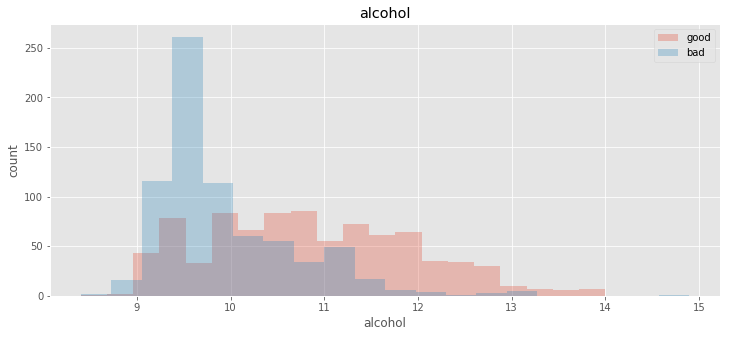

In [17]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [18]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [20]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [21]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [22]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [23]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [24]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [25]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [26]:
from sklearn.base import BaseEstimator
from sklearn.base import ClusterMixin

class mKmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, eps = 0.001, random_state=None, init='random', verbose = False):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        :init - метод инициализации 'random' or 'k-means'
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.eps = eps
        self.verbose = verbose
        
    def init_random(self, X):
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        indexes = np.random.randint(0, high = X.shape[0] , size=self.k)
       # print indexes
        self.centroids = X[indexes]
        #print self.centroids
        return self
    
    def init_kpp(self, X):
        
        self.centroids = np.empty((self.k, X.shape[1]))
        
        
        # set first centroid
        self.centroids[0] = X[np.random.randint(0, high = X.shape[0])]
        #print "Initial centroid: {0}\n".format(self.centroids[:1])
        
        
        for c_count in range(1, self.k):
           # print "----------------------------\n"
            distances_sq = (np.square((X[np.newaxis,:] - self.centroids[:c_count, np.newaxis]))).sum(axis = 2)   
            
            Dsq = np.min(distances_sq, axis = 0)
            D_sum_sq = np.sum(Dsq, axis = 0)
            
            probs = Dsq/D_sum_sq  
            
            self.centroids[c_count] = X[np.random.choice(X.shape[0], size = 1, replace=False, p=probs)]
            #c_count+= 1
            
#             if self.verbose == True:
#                 print "Distances_sq: {0}\n".format(distances_sq)
#                 print "D^2: {0}\n".format(Dsq)
#                 print "D^2-sum: {0}\n".format(D_sum_sq)
#                 print "Probabylities: {0}\n".format(probs)
#                 print "Centroids: Count: {0} \n {1}\n".format(c_count, self.centroids)
#                 print "-------------------------\n"
                    
        return self
    
    
    def initialize(self, X):
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        if self.init == 'random':
            self.init_random(X)
        elif self.init == 'k-means':
            self.init_kpp(X)
        return self

    
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """        
        
        self.initialize(X)
        
#         if self.verbose == True:           
#             print "CENTROIDS START:\n"
#             print self.centroids
#             prev_centroids = self.centroids

#             print "X START:\n"
#             print X[:10]

#             print "1 DISTANCES START:\n"
#             print ((X[:, np.newaxis] - self.centroids[np.newaxis,:])**2).sum(axis=2)

#             print "2 DISTANCES START:\n"
#             print X[:, np.newaxis] - self.centroids[np.newaxis,:]

#             print "2 DIST SQARED\n"
#             print ((X[:, np.newaxis] - self.centroids[np.newaxis,:])**2).sum(axis = 2)
        
        iters = 1
        while iters < self.max_iter:
            
            prev_centroids = self.centroids
            
            
            #distances = ((X[:, np.newaxis] - self.centroids[np.newaxis,:])**2).sum(axis = 2)
            distances = X[np.newaxis,:] - self.centroids[:,np.newaxis]
            distances = np.square(distances)
            distances = np.sum(distances, axis = 2)
            #distances = ((X - self.centroids[:, np.newaxis])**2).sum(axis = 2)
            mincentroids = np.argmin(distances, axis = 0)
            
#             if self.verbose == True:
#                 print "Iter: " + str(iters) + "\n" 
#                 print "Centroids: \n"
#                 print self.centroids
#                 print "Distances: \n"
#                 print distances
#                 print "Minimum centroids"
#                 print mincentroids
#                 print "Центроиды: \n"
#                 print self.centroids

#                 print "------------\n"
            
            
            self.centroids = np.array([X[mincentroids == k].mean(axis=0) for k in range(self.centroids.shape[0])])
            
            #if np.linalg.norm(prev_centroids - self.centroids) < self.eps:
            if np.sqrt(np.square(prev_centroids - self.centroids).sum(axis=1).max()) < self.eps:
                break
             
            iters+=1
        
        
        #print "Iterations: " + str(iters);
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        
        distances = (np.square((X - self.centroids[:, np.newaxis]))).sum(axis=2)
        mincentroids = np.argmin(distances, axis=0)
     
        
        return mincentroids

class mMiniBatchKMeans(mKmeans):
    
    def __init__(self, k=2, metric='euclidean', batch_size = 100, max_iter=1000, random_state=None, 
                 init='random', verbose = False):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :batch_size - Size of the mini batches
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        :init - метод инициализации 'random' or 'k-means++'
        """
        super(mMiniBatchKMeans, self).__init__(k=k, metric=metric, max_iter=max_iter, 
                                              random_state = random_state, init=init, verbose=verbose)
        self.batch_size = batch_size
        
        
        
    
    def fit(self, X, y=None):
        """
        Процедура обучения Mini-Batch k-means
        """  
        
        self.initialize(X)
        
        V = np.zeros(self.k)
        
        random_indexes = np.random.randint(0, X.shape[0], (self.max_iter, self.batch_size))
        
        for it in range(1,self.max_iter):
            #M = X[np.random.randint(0, high = X.shape[0], size=self.batch_size)]
            M = X[random_indexes[it]]
            
            #distances = ((M - self.centroids[:, np.newaxis])**2).sum(axis=2)
#             distances = (np.square((M - self.centroids[:, np.newaxis]))).sum(axis=2)
            ind_minMcentroids = np.argmin((np.square((M - self.centroids[:, np.newaxis]))).sum(axis=2), axis=0) # indexes of closest centroid for each x in X (by index)
            #D = self.centroids[ind_minMcentroids] # minimal centroids to each x in X (by index)
            
#             if self.verbose == True:
#                 print "-----------\n"
#                 print "Step:{0}\n".format(it)
#                 print "Distances: {0}\n".format(distances)
#                 print "ind_minMcentroids: {0}\n".format(ind_minMcentroids)
#                 print "D:{0}\n".format(D)
#                 print "Centroids:{0}\n".format(self.centroids)
#                 print "-Update centers:\n"
#                 np.add()
            
            
            
            for m_ind in range(0,M.shape[0]):
                c_ind = ind_minMcentroids[m_ind]
                V[c_ind] += 1
                nu = 1/V[c_ind]
                self.centroids[c_ind] = (1-nu)*self.centroids[c_ind] + nu*M[m_ind]
                
#                 if self.verbose == True:
#                     print " ---update_centers----\n"
#                     print " Step:{0}\n".format(m_ind)
#                     print " V:{0}\n".format(V)
#                     print " centroids:{0}\n".format(self.centroids)
        
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [27]:
from sklearn.datasets import make_blobs

In [28]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=5678)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

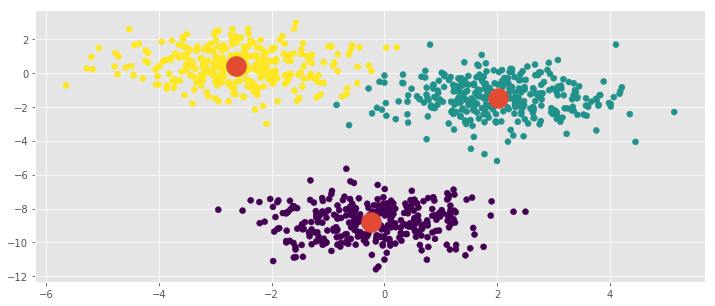

In [29]:
## Работоспособность KMeans
model = mKmeans(k=3)
model.fit(X)
y = model.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(model.centroids[:,0], model.centroids[:,1], s=400)

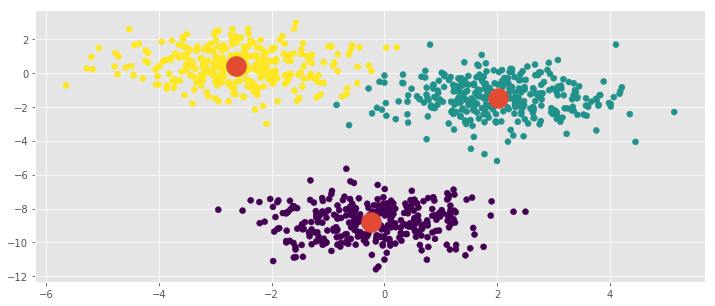

In [30]:
## Работоспособность KMeans++
model = mKmeans(k=3, init = 'k-means')
model.fit(X)

y = model.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(model.centroids[:,0], model.centroids[:,1], s=400)

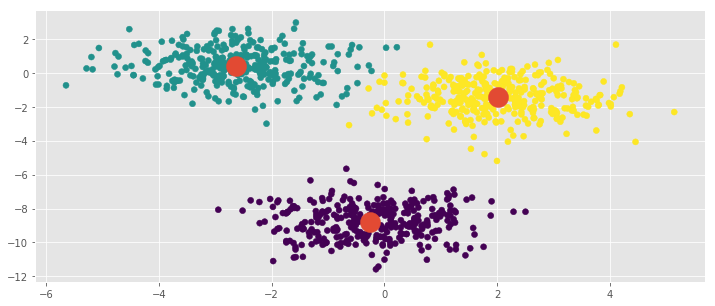

In [31]:
## Работоспособность KMeans с MiniBatchKMeans
model = mMiniBatchKMeans(k=3, batch_size=100)
model.fit(X)
y = model.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(model.centroids[:,0], model.centroids[:,1], s=400)

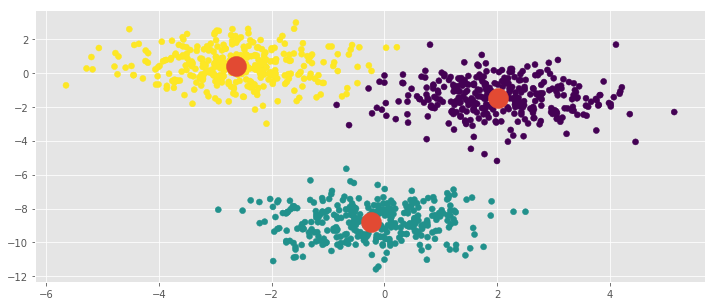

In [32]:
## Работоспособность KMeans++ с MiniBatchKMeans
model = mMiniBatchKMeans(k=3, batch_size=100, init = 'k-means')
model.fit(X)
y = model.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(model.centroids[:,0], model.centroids[:,1], s=400)

In [33]:
# generate data for algorithms tests
test_data = []
centers_count = 9
count_ranges = np.array([x for x in range(1000, 10000, 1000)])

print count_ranges

for i in count_ranges:
    X, y = make_blobs(n_samples=i, n_features=2, centers=centers_count, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    test_data.append(X)

[1000 2000 3000 4000 5000 6000 7000 8000 9000]


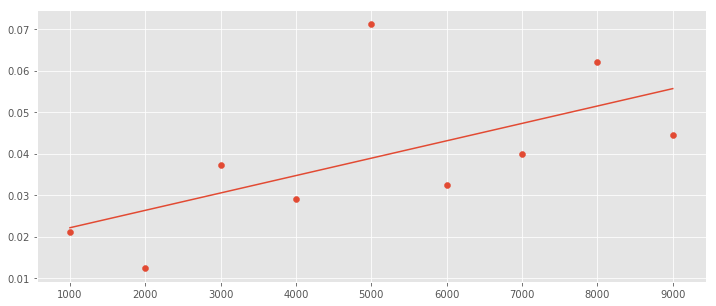

In [34]:
## Время выполнения алгоритма KMeans
model = mKmeans(k=centers_count)
alg_time_results = np.empty((0, ))

for X in test_data:
    result = %timeit -o -q -n 1 -r 1 model.fit(X)
    alg_time_results = np.append(alg_time_results, result.best)

m, b = np.polyfit(count_ranges, alg_time_results, deg=1)
plt.plot(count_ranges, m * count_ranges + b, '-')
plt.scatter(count_ranges, alg_time_results)

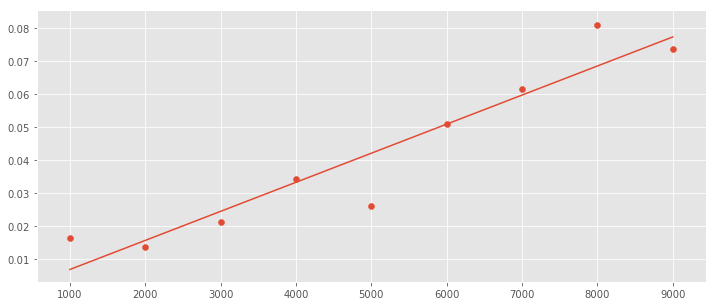

In [35]:
## Время выполнения алгоритма KMeans++
model = mKmeans(k=centers_count, init = 'k-means')
alg_time_results = np.empty((0, ))

for X in test_data:
    result = %timeit -o -q -n 1 -r 1 model.fit(X)
    alg_time_results = np.append(alg_time_results, result.best)

m, b = np.polyfit(count_ranges, alg_time_results, deg=1)
plt.plot(count_ranges, m * count_ranges + b, '-')
plt.scatter(count_ranges, alg_time_results)

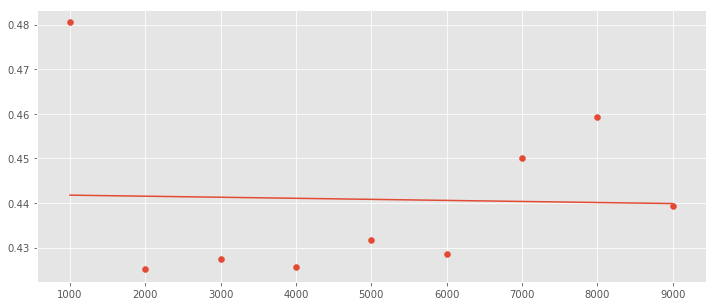

In [36]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
model = mMiniBatchKMeans(k = centers_count)
alg_time_results = np.empty((0, ))

for X in test_data:
    result = %timeit -o -q -n 1 -r 1 model.fit(X)
    alg_time_results = np.append(alg_time_results, result.best)

m, b = np.polyfit(count_ranges, alg_time_results, deg=1)
plt.plot(count_ranges, m * count_ranges + b, '-')
plt.scatter(count_ranges, alg_time_results)

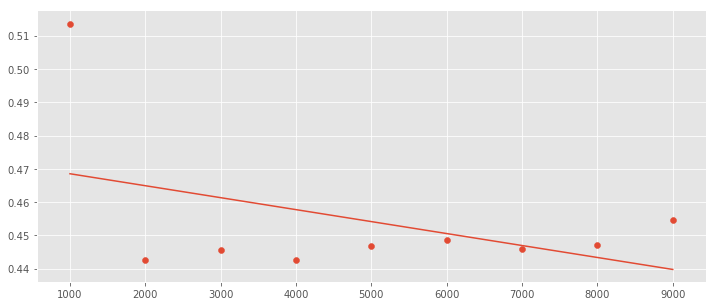

In [37]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
model = mMiniBatchKMeans(k = centers_count, init = 'k-means')
alg_time_results = np.empty((0, ))

for X in test_data:
    result = %timeit -o -q -n 1 -r 1 model.fit(X)
    alg_time_results = np.append(alg_time_results, result.best)

m, b = np.polyfit(count_ranges, alg_time_results, deg=1)
plt.plot(count_ranges, m * count_ranges + b, '-')
plt.scatter(count_ranges, alg_time_results)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [49]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df = df_sns.drop(['gradyear','gender','age','friends'], axis = 1)
df.head()
df.fillna(df.mean())
df.columns

Index([u'basketball', u'football', u'soccer', u'softball', u'volleyball',
       u'swimming', u'cheerleading', u'baseball', u'tennis', u'sports',
       u'cute', u'sex', u'sexy', u'hot', u'kissed', u'dance', u'band',
       u'marching', u'music', u'rock', u'god', u'church', u'jesus', u'bible',
       u'hair', u'dress', u'blonde', u'mall', u'shopping', u'clothes',
       u'hollister', u'abercrombie', u'die', u'death', u'drunk', u'drugs'],
      dtype='object')

In [50]:
df=(df-df.mean())/df.std()
df.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


In [51]:
X = df.values

In [52]:
from line_profiler import LineProfiler
def profile_print(func_to_call, *args):
    profiler = LineProfiler()
    profiler.add_function(func_to_call)
    profiler.runcall(func_to_call, *args)
    profiler.print_stats()

In [54]:
## KMeans
kmeans = mKmeans(k=9, eps=0.001, init='random')
%timeit kmeans.fit(X)
y_kmeans = kmeans.predict(X)
print df.columns[(np.absolute(kmeans.centroids.copy())).argsort()[:,::-1][:,:6]]

1 loop, best of 3: 1.76 s per loop
Index([[u'marching', u'band', u'music', u'hollister', u'abercrombie', u'basketball'],
       [u'death', u'die', u'hollister', u'football', u'shopping', u'abercrombie'],
       [u'basketball', u'softball', u'baseball', u'football', u'volleyball', u'sports'],
       [u'death', u'shopping', u'hair', u'cute', u'clothes', u'mall'],
       [u'hollister', u'abercrombie', u'shopping', u'mall', u'clothes', u'hair'],
       [u'sexy', u'cute', u'hot', u'sex', u'hair', u'rock'],
       [u'shopping', u'cute', u'dress', u'mall', u'dance', u'clothes'],
       [u'kissed', u'drugs', u'hair', u'sex', u'drunk', u'die'],
       [u'bible', u'jesus', u'god', u'church', u'music', u'death']],
      dtype='object')


In [55]:
#Сравнение с Kmeans из sklearn
from sklearn import cluster
# model = cluster.KMeans(n_clusters=9, max_iter=1000, init='random', n_init=10, tol=0.001, precompute_distances = False, 
#                       n_jobs = 1, algorithm = 'full')
model = cluster.KMeans(n_clusters=9)
%timeit model.fit(X)

1 loop, best of 3: 2.67 s per loop


In [56]:
clc_km =[]
for i in range(0,9):
    clc_km.append((y_kmeans==i).sum())
clc_km

[739, 1854, 2348, 18568, 855, 549, 3799, 839, 449]

In [57]:
## KMeans++
kpp = mKmeans(k=9,eps=0.001, init = 'k-means')
%timeit kpp.fit(X)
kpp_y = kpp.predict(X)
print df.columns[(np.absolute(kpp.centroids.copy())).argsort()[:,::-1][:,:6]]

1 loop, best of 3: 2.66 s per loop
Index([[u'kissed', u'drugs', u'hair', u'drunk', u'sex', u'die'],
       [u'shopping', u'cute', u'dance', u'church', u'dress', u'mall'],
       [u'football', u'basketball', u'baseball', u'sports', u'volleyball', u'tennis'],
       [u'shopping', u'football', u'hair', u'cute', u'clothes', u'basketball'],
       [u'soccer', u'sports', u'shopping', u'football', u'basketball', u'swimming'],
       [u'blonde', u'sex', u'drunk', u'death', u'hair', u'die'],
       [u'hollister', u'abercrombie', u'shopping', u'mall', u'clothes', u'hair'],
       [u'softball', u'basketball', u'volleyball', u'sports', u'shopping', u'church'],
       [u'sex', u'hair', u'hollister', u'kissed', u'church', u'drugs']],
      dtype='object')


In [58]:
clc_kmpp =[]
for i in range(0,9):
    clc_kmpp.append((kpp_y==i).sum())
clc_kmpp

[983, 4849, 2200, 19913, 692, 1, 850, 509, 3]

In [65]:
## KMeans с MiniBatchKMeans
mbk = mMiniBatchKMeans(batch_size=100, k=9)
%timeit mbk.fit(X)
mbk_y = mbk.predict(X)
print df.columns[(np.absolute(mbk.centroids.copy())).argsort()[:,::-1][:,:6]]

1 loop, best of 3: 570 ms per loop
Index([[u'kissed', u'drugs', u'drunk', u'hair', u'die', u'sex'],
       [u'tennis', u'church', u'sports', u'soccer', u'swimming', u'basketball'],
       [u'sex', u'kissed', u'blonde', u'hair', u'drugs', u'death'],
       [u'marching', u'band', u'music', u'hollister', u'rock', u'volleyball'],
       [u'volleyball', u'softball', u'basketball', u'sports', u'shopping', u'football'],
       [u'shopping', u'hair', u'mall', u'cute', u'clothes', u'church'],
       [u'church', u'shopping', u'dance', u'god', u'dress', u'mall'],
       [u'hot', u'sexy', u'soccer', u'softball', u'baseball', u'basketball'],
       [u'hollister', u'abercrombie', u'shopping', u'mall', u'clothes', u'hair']],
      dtype='object')


In [66]:
clc_mbk =[]
for i in range(0,9):
    clc_mbk.append((mbk_y==i).sum())
clc_mbk

[1179, 244, 21, 589, 720, 20142, 4327, 1925, 853]

In [61]:
## KMeans++ с MiniBatchKMeans
mbkpp = mMiniBatchKMeans(batch_size=100, k=9, init='k-means')
%timeit mbkpp.fit(X)
mbkpp_y = mbkpp.predict(X)
print df.columns[(np.absolute(mbkpp.centroids.copy())).argsort()[:,::-1][:,:6]]

1 loop, best of 3: 740 ms per loop
Index([[u'abercrombie', u'hollister', u'shopping', u'hair', u'clothes', u'mall'],
       [u'shopping', u'dance', u'cute', u'clothes', u'dress', u'mall'],
       [u'drunk', u'softball', u'drugs', u'hair', u'die', u'death'],
       [u'tennis', u'swimming', u'sports', u'church', u'soccer', u'basketball'],
       [u'marching', u'band', u'music', u'football', u'rock', u'hollister'],
       [u'bible', u'jesus', u'god', u'death', u'clothes', u'church'],
       [u'shopping', u'football', u'hair', u'clothes', u'basketball', u'mall'],
       [u'kissed', u'sex', u'hair', u'rock', u'drugs', u'music'],
       [u'football', u'basketball', u'baseball', u'church', u'sports', u'god']],
      dtype='object')


In [62]:
clc_mbkpp =[]
for i in range(0,9):
    clc_mbkpp.append((mbkpp_y==i).sum())
clc_mbkpp

[858, 3963, 998, 245, 428, 1, 19295, 680, 3532]

## Вывод

Попробуем использовать для анализа работы алгоритмов первые 6 признаков каждого получившегося центроида, максимально 
удаленные от 0 (уже после нормализации данных), а также количество объектов в каждом кластере.

Из получившегося видно, что алгоритмы k-means и kmeans++ выдают очень похожий результат. 
Их центроиды почти отличаются друг от друга, если сравнить их признаки вносящие наибольший вклад.
Чисто визуально можно интерпретировать центроиды получившихся кластеров, 
по первым признакам понятны основные интересы кластера пользователей. 
Но они немного сдвинуты, из-за чего размеры кластеров не совпадают точно.

Алгоритмы MiniBatchKMeans и MiniBatchKMeans с Kmeans++ показывают уже сильнее отличающиеся результаты.
Размеры кластеров почти совпадает с k-means и kmeans++. Но существенно отличаются первые 6 признаков. 
Почти все признаки центроидов из k-means присутствуют в описании, но их порядок другой и он меняется при повторном запуске алгоритма.
Порядок признаков также ощутимо отличается между MiniBatchKMeans и MiniBatchKMeans с Kmeans++.

Из этого можно сделать вывод, что алгоритмы k-means и kmeans++ устойчивее (особенно kmeans++), показывают более достоверный 
и легко интерпертируемый результат, по сравнению с MiniBatchKMeans и MiniBatchKMeans с Kmeans++.
Поэтому из данных алгоритмов самым надежным и выдающем наиболее правдоподобный явлется kmeans++, хотя при этом и наиболее ресурсоёмкий.



